# Requirements

In [1]:
import os

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset
import cv2

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <A0E0B741-848C-3144-924F-2971884DA4EF> /Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <6384E44A-E10D-30C9-994F-E34B0519E5B3> /Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Data

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, transforms = None, padding = None):
        super().__init__()
        self.paths = paths
        self.transforms = transforms
        self.pad = padding
        
    def __len__(self):
        return len(self.paths)
        
    def __getitem__(self, ind):
        
        img = cv2.imread(paths[ind])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.pad != None:
            img = self.pad(image = img)['image']
            
        if self.transforms != None:
            img = self.transforms(img)
        
        return img

In [3]:
root_dir = 'naruto-face-dataset'

In [4]:
paths = []

In [5]:
for folder in os.listdir(root_dir):
    if folder == '.DS_Store' or folder == '.ipynb_checkpoints':
        continue
    folder_path = os.path.join(root_dir, folder)
    for file in os.listdir(folder_path):
        if file == '.DS_Store' or file == '.ipynb_checkpoints':
            continue
        paths.append(os.path.join(folder_path, file))

In [6]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

In [7]:
dataset = Dataset(paths)

Show some samples from dataset

In [8]:
n_samples = 6
cols = 3

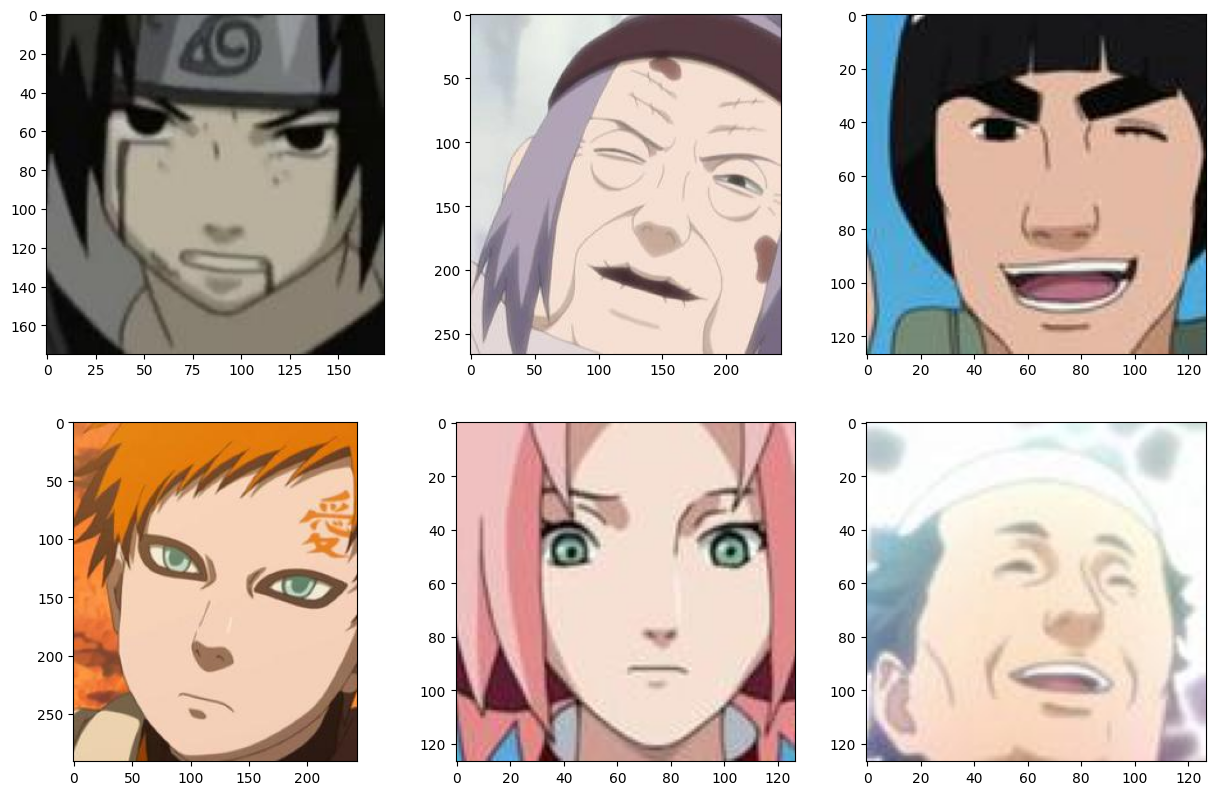

In [9]:
plt.figure(figsize=(15,15))
for i in range(n_samples):
    img = dataset[i]
    plt.subplot(n_samples//cols + 1, cols, i + 1)
    plt.imshow(img)

# Data Processing

In [10]:
image_size = 128 
transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(size = (image_size, image_size)),
    ])
pad = A.Compose([
    A.PadIfNeeded(image_size, image_size, value = 0)
])

In [11]:
transformed_dataset = Dataset(paths, transforms, pad)

# Model

In [12]:
class VAE(nn.Module):
    
    
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        self.encoder =  nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 5, stride=2, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size = 5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size = 5, stride=2, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size = 5, stride=2, padding=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
        )

        self.flatten = nn.Flatten()
        self.mu = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )
        
        self.ln_var = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.decoder = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
        
    def encode(self, x):
        z = self.encoder(x)
        z = self.flatten(z)
        ln_var = self.ln_var(z)
        mu = self.mu(z)
        epsilon = torch.Tensor(np.random.normal(size=(self.hidden_dim), scale=1.0)).to(x.device)
        z = mu + epsilon * torch.exp(ln_var / 2)
        return z, mu, ln_var
    
        
    def decode(self, z):
        z = z.reshape((z.shape[0], 128, 8, 8))
        x_rec = self.decoder(z)
        return x_rec
    
    
    def compute_kl_div(self, mu, ln_var):
        kl = 1 + ln_var - mu ** 2 - ln_var.exp()
        kl = kl.sum(dim = 1) * (-0.5)
        kl = kl.mean(dim = 0)
        return kl
    
    
    def forward(self, x):
        z, mu, ln_var = self.encode(x)
        z = self.decode(z)
        
        return z, mu, ln_var

In [13]:
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.to(device)
    model.train()

    total_loss = 0.0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()

        images = batch.to(device)
        preds, mu, ln_var = model(images)
        
        loss = loss_fn(preds, images) + kl_div_loss(mu, ln_var)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [14]:
def weights_init_xavier(m):
    classname = m.__class__.__name__

    if classname.find('Linear') != -1:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [33]:
loss_fn = torch.nn.MSELoss()
model = VAE(8192)
model.apply(weights_init_xavier)
dataloader = torch.utils.data.DataLoader(transformed_dataset,
                                        batch_size = 40,
                                        shuffle = True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = 'mps'

/var/folders/sm/zp4frk3174zc8vhh_l6v9byh0000gn/T/ipykernel_25131/2054984732.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [34]:
epochs = 30

In [35]:
train_losses = []

In [36]:
def kl_div_loss(mu, log_var):
    kl = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
    return kl

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:10<00:00,  2.51it/s]

Epoch: 0 Train_loss: 0.0710454375856677


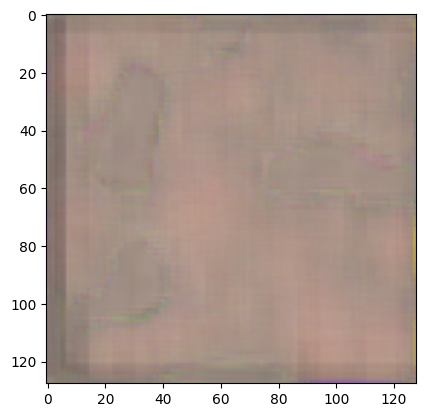

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:09<00:00,  2.55it/s]


Epoch: 1 Train_loss: 0.07107142228527931


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:09<00:00,  2.54it/s]


Epoch: 2 Train_loss: 0.07109537891159623


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:11<00:00,  2.49it/s]


Epoch: 3 Train_loss: 0.07100226431243163


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:09<00:00,  2.54it/s]


Epoch: 4 Train_loss: 0.07094741625300909


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:09<00:00,  2.56it/s]

Epoch: 5 Train_loss: 0.07100374300011807


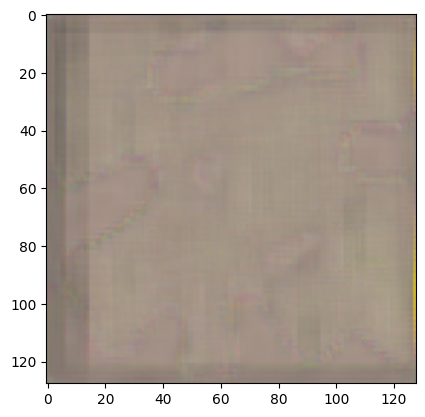

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:10<00:00,  2.50it/s]


Epoch: 6 Train_loss: 0.07101155352373581


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:11<00:00,  2.48it/s]


Epoch: 7 Train_loss: 0.07094477279122266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:12<00:00,  2.44it/s]


Epoch: 8 Train_loss: 0.07091142626552932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:11<00:00,  2.46it/s]


Epoch: 9 Train_loss: 0.07089260308924368


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:10<00:00,  2.52it/s]

Epoch: 10 Train_loss: 0.07086156327593124


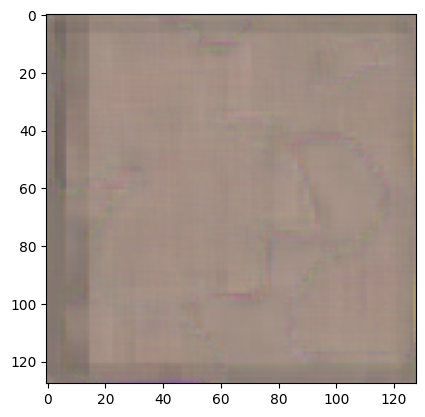

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:22<00:00,  2.14it/s]


Epoch: 11 Train_loss: 0.07084316713998547


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:25<00:00,  2.07it/s]


Epoch: 12 Train_loss: 0.07091532163532441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:27<00:00,  2.03it/s]


Epoch: 13 Train_loss: 0.07086016151443714


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:28<00:00,  2.00it/s]


Epoch: 14 Train_loss: 0.07082663394384466


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:28<00:00,  1.99it/s]

Epoch: 15 Train_loss: 0.07091536688602577


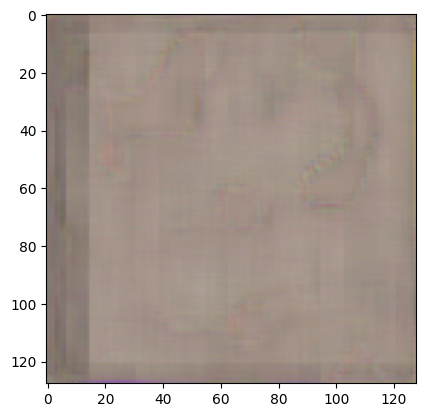

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:25<00:00,  2.07it/s]


Epoch: 16 Train_loss: 0.07081975547944085


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:27<00:00,  2.03it/s]


Epoch: 17 Train_loss: 0.070834948897025


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:29<00:00,  1.97it/s]


Epoch: 18 Train_loss: 0.07084537907845556


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:27<00:00,  2.02it/s]


Epoch: 19 Train_loss: 0.07079273359166027


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:27<00:00,  2.02it/s]

Epoch: 20 Train_loss: 0.07082413835714092


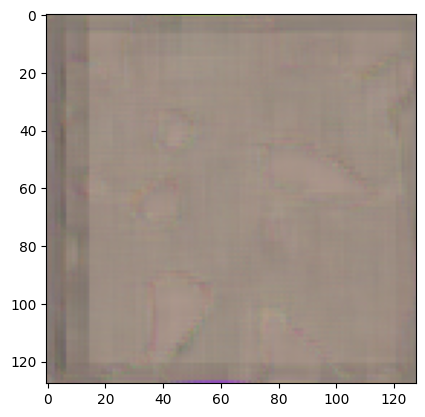

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:27<00:00,  2.03it/s]


Epoch: 21 Train_loss: 0.0708425859315584


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:27<00:00,  2.01it/s]


Epoch: 22 Train_loss: 0.07073585956362681


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:49<00:00,  1.62it/s]


Epoch: 23 Train_loss: 0.07074151447011252


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:28<00:00,  2.00it/s]


Epoch: 24 Train_loss: 0.07074544467242425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:28<00:00,  2.00it/s]

Epoch: 25 Train_loss: 0.07077426614902788


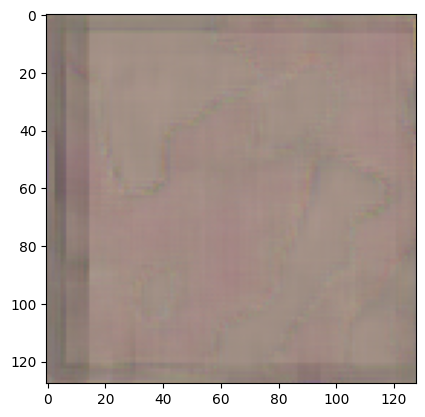

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:31<00:00,  1.94it/s]


Epoch: 26 Train_loss: 0.07071095347236105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:30<00:00,  1.96it/s]


Epoch: 27 Train_loss: 0.07077143417071488


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:32<00:00,  1.91it/s]


Epoch: 28 Train_loss: 0.0706963824939593


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 177/177 [01:31<00:00,  1.93it/s]

Epoch: 29 Train_loss: 0.07075543129174723


In [38]:
for epoch_i in range(epochs):
    train_loss = train_epoch(model, dataloader, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    print(f'Epoch: {epoch_i} Train_loss: {train_loss}')
    if epoch_i % 5 == 0:
        model.eval()
        with torch.no_grad():
            rec_images = model(transformed_dataset[2].unsqueeze(0).to('mps'))
        plt.imshow(rec_images[0][0].permute(1, 2, 0).cpu().numpy())
        plt.show()

In [30]:
model.eval()
with torch.no_grad():
    rec_images = model(transformed_dataset[2].unsqueeze(0).to('mps'))

In [31]:
rec_images[0]

/Users/len/anaconda3/envs/py_projects/lib/python3.10/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


tensor([[[[0.5388, 0.5788, 0.5768,  ..., 0.6076, 0.5908, 0.5506],
          [0.5281, 0.6102, 0.5497,  ..., 0.6307, 0.5836, 0.6148],
          [0.5010, 0.5262, 0.4861,  ..., 0.5621, 0.5777, 0.6373],
          ...,
          [0.4555, 0.5074, 0.5349,  ..., 0.6708, 0.6091, 0.5791],
          [0.4878, 0.4957, 0.5273,  ..., 0.6088, 0.5980, 0.5822],
          [0.4937, 0.5077, 0.5202,  ..., 0.5212, 0.5320, 0.5965]],

         [[0.4059, 0.4913, 0.4412,  ..., 0.5187, 0.5435, 0.4434],
          [0.3208, 0.4792, 0.4099,  ..., 0.4986, 0.5508, 0.4670],
          [0.3152, 0.4717, 0.3534,  ..., 0.4994, 0.5624, 0.4825],
          ...,
          [0.5547, 0.5207, 0.5126,  ..., 0.5758, 0.6202, 0.5180],
          [0.5437, 0.4891, 0.4874,  ..., 0.4948, 0.5531, 0.4851],
          [0.5292, 0.5207, 0.5038,  ..., 0.4843, 0.5181, 0.4419]],

         [[0.4635, 0.5715, 0.5106,  ..., 0.4896, 0.5213, 0.5940],
          [0.4052, 0.4665, 0.4403,  ..., 0.5115, 0.5209, 0.4940],
          [0.3443, 0.4677, 0.4190,  ..., 0

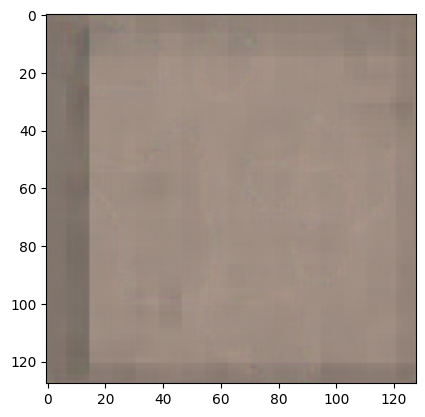

In [125]:
plt.imshow(rec_images[0][0].permute(1, 2, 0).cpu().numpy())

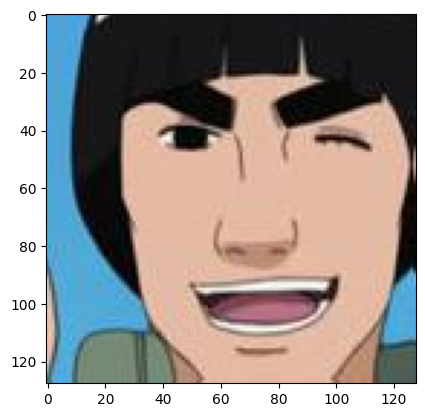

In [126]:
plt.imshow(transformed_dataset[2].permute(1,2,0))